In [1]:
import torch
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as measures
from scipy import stats

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Matplotlib is building the font cache; this may take a moment.


In [3]:
from code_deepQueueNet.model import DeepQueueNet
from code_deepQueueNet.config import BaseConfig, modelConfig

In [10]:
train_file = 'data/train.h5'
test1_file = 'data/test1.h5'
test2_file = 'data/test2.h5'
scaler_folder = 'scaler'
temp_folder = 'temp/'
results_folder = 'results/'

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
state_path = './trained_models/best_epoch_100.ckpt'
base_config = BaseConfig()
model_config = modelConfig()
model = DeepQueueNet(config=BaseConfig, device=device)
model.to(device)
model.eval()
model.load_state_dict(torch.load(state_path,  map_location=device)['state_dict'])

<All keys matched successfully>

In [8]:
def load_sample(task, file):
    with h5py.File(file, 'r') as hdf:
        x = hdf['x'][:]
        y = hdf['y'][:]
    return x, y

In [11]:
x1,y1=load_sample('test1', test1_file)
x2,y2=load_sample('test2', test2_file)
x,y=load_sample('train', train_file)

In [12]:
y_pred = []
batch_size = 1024
x = torch.from_numpy(x).float()
chuncked_x = torch.split(x, batch_size,0)
for sample in chuncked_x:
    sample = sample.to(device)
    y_pred.extend(model(sample).detach().cpu().numpy())

In [15]:
y_pred = np.array(y_pred)
np.save(temp_folder + "y_pred.npy",y_pred)

y1_pred = []
batch_size = 1024
x1 = torch.from_numpy(x1).float()
chuncked_x1 = torch.split(x1, batch_size,0)
for sample in chuncked_x1:
    sample = sample.to(device)
    y1_pred.extend(model(sample).detach().cpu().numpy())

y1_pred = np.array(y1_pred)
np.save(temp_folder + "y1_pred.npy",y1_pred)

y2_pred = []
x2 = torch.from_numpy(x2).float()
chuncked_x2 = torch.split(x2, batch_size,0)
for sample in chuncked_x2:
    sample = sample.to(device)
    y2_pred.extend(model(sample).detach().cpu().numpy())

y2_pred = np.array(y2_pred)
np.save(temp_folder + "y2_pred.npy",y2_pred)

In [16]:
x_MIN=pd.read_csv(scaler_folder+'/x_MIN.csv', names=['key','value']).set_index('key')['value']
x_MAX=pd.read_csv(scaler_folder+'/x_MAX.csv', names=['key','value']).set_index('key')['value']
y_MIN=pd.read_csv(scaler_folder+'/y_MIN.csv', names=['key','value']).set_index('key')['value']
y_MAX=pd.read_csv(scaler_folder+'/y_MAX.csv', names=['key','value']).set_index('key')['value']
fet_cols=list(x_MIN.keys())
target=list(y_MIN.keys())

y_MAX=y_MAX['time_in_sys']
y_MIN=y_MIN['time_in_sys']

y_RANGE=y_MAX-y_MIN
print(y_RANGE)
print(y_MIN)

y1_pred = np.array(y1_pred)
y2_pred = np.array(y2_pred)
y_pred = np.array(y_pred)

y =y*y_RANGE+y_MIN 
y1=y1*y_RANGE+y_MIN 
y2=y2*y_RANGE+y_MIN 
y_pred =y_pred*y_RANGE+y_MIN 
y1_pred=y1_pred*y_RANGE+y_MIN 
y2_pred=y2_pred*y_RANGE+y_MIN

y_pred = y_pred.reshape(-1)
y1_pred = y1_pred.reshape(-1)
y2_pred = y2_pred.reshape(-1)
y = y.reshape(-1)
y1 = y1.reshape(-1)
y2 = y2.reshape(-1)

0.017401255998000003
2.5177002e-05


In [17]:
coll={'train': [131, y*1e3, y_pred*1e3], 
'test: endogeny': [132, y1*1e3, y1_pred*1e3],
'test: exogenesis': [133, y2*1e3, y2_pred*1e3]}

print(coll['test: endogeny'][1][3],coll['test: endogeny'][2][3])

0.54397585 0.0706593


Text(0.5, 0.98, 'regression plot\n\n\n\n\n')

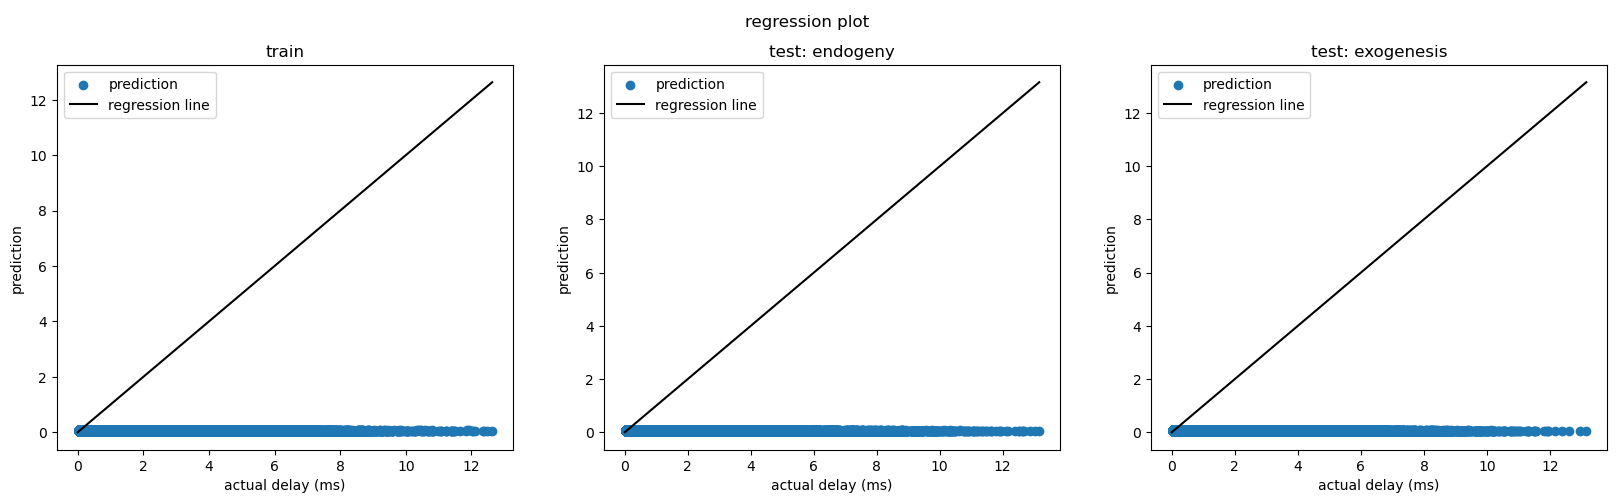

In [18]:
plt.figure(figsize=(20,5))
for k, v in coll.items():
    Max =max(max(v[1]),  max(v[2]))
    plt.subplot(v[0])
    plt.scatter(v[1], v[2],label='prediction')
    plt.plot([0,Max],[0,Max], color='k',label='regression line')
    plt.legend()
    plt.xlabel('actual delay (ms)')
    plt.ylabel('prediction')
    plt.title('\n\n{}'.format(k))
plt.suptitle('regression plot\n\n\n\n\n')

In [20]:
Result=pd.DataFrame(y, columns=['delay'])
Result['prediction']=y_pred
Result['error']=y_pred-y
Result['priority']=0
Result.to_csv(results_folder + 'train.csv', index=False)
Result1=pd.DataFrame(y1, columns=['delay'])
Result1['prediction']=y1_pred
Result2=pd.DataFrame(y2, columns=['delay'])
Result2['prediction']=y2_pred

Result.to_csv(results_folder + "tzzs_data.csv")
print(Result)

          delay  prediction     error  priority
0      0.000050    0.000072  0.000021         0
1      0.000805    0.000071 -0.000734         0
2      0.000025    0.000072  0.000046         0
3      0.000025    0.000071  0.000046         0
4      0.001454    0.000071 -0.001383         0
...         ...         ...       ...       ...
75875  0.000542    0.000069 -0.000473         0
75876  0.001414    0.000069 -0.001345         0
75877  0.000544    0.000071 -0.000473         0
75878  0.000591    0.000069 -0.000522         0
75879  0.000740    0.000071 -0.000669         0

[75880 rows x 4 columns]


In [21]:
def pdf_cdf(df,disp):
    plt.figure(figsize=(16,5))
    plt.subplot(121)
    bins=np.histogram(np.hstack((df['delay'].values, df['prediction'].values)), bins=100)[1]  
    plt.hist(df['delay'].values, bins, density=False,  histtype='step', label='delay', lw=1.5);
    plt.hist(df['prediction'].values, bins, density=False,  histtype='step', label='prediction',linestyle=':',lw=1.5);
    plt.title('pdf')
    plt.legend(frameon=False, loc="best")

    plt.subplot(122)
    _res=stats.relfreq(df['delay'].values, numbins=100)
    res_=stats.relfreq(df['prediction'].values, numbins=100)
    _x=_res.lowerlimit + np.linspace(0, _res.binsize*_res.frequency.size, _res.frequency.size)
    _y=np.cumsum(_res.frequency)
    x_=res_.lowerlimit + np.linspace(0, res_.binsize*res_.frequency.size, res_.frequency.size)
    y_=np.cumsum(res_.frequency)
    plt.plot(_x, _y,label='delay',lw=1.5)
    plt.plot(x_, y_,  linestyle=':', label='prediction',lw=1.5)
    plt.title('cdf');
    plt.legend(frameon=False, loc="best")
    plt.suptitle('delay analysis: {}'.format(disp))

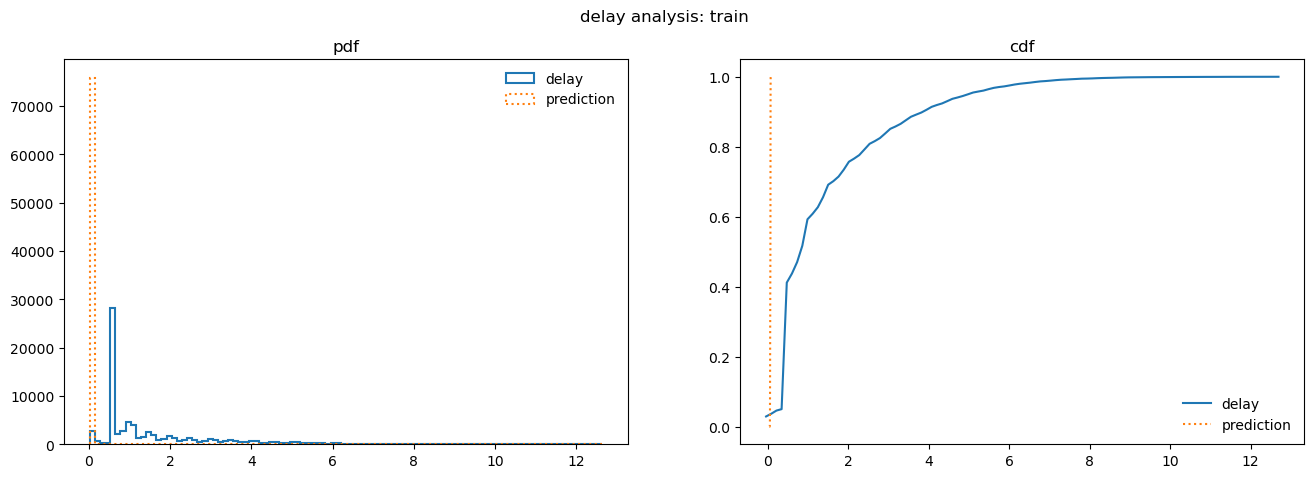

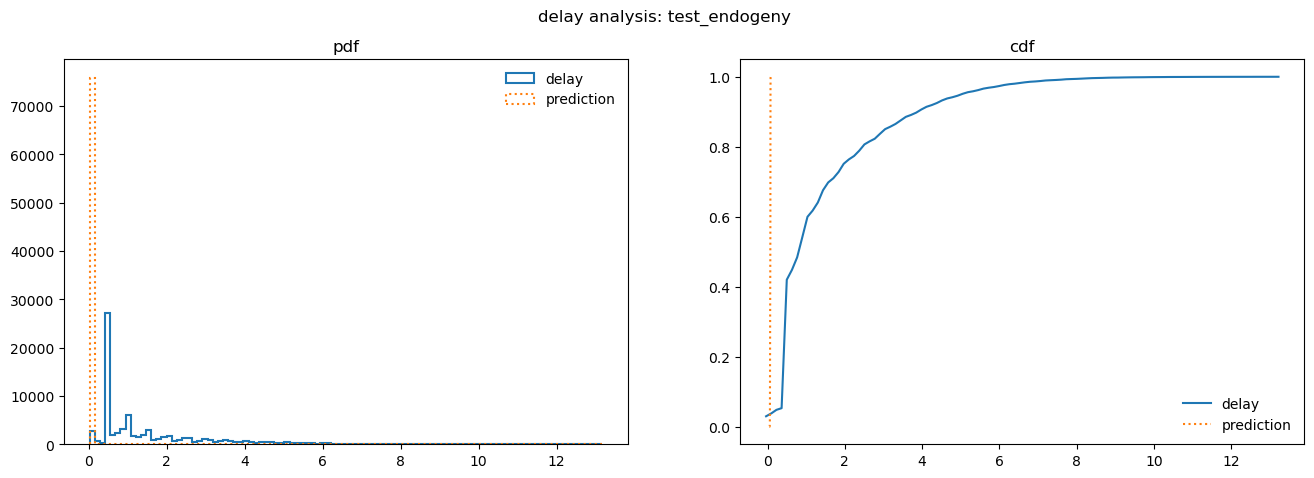

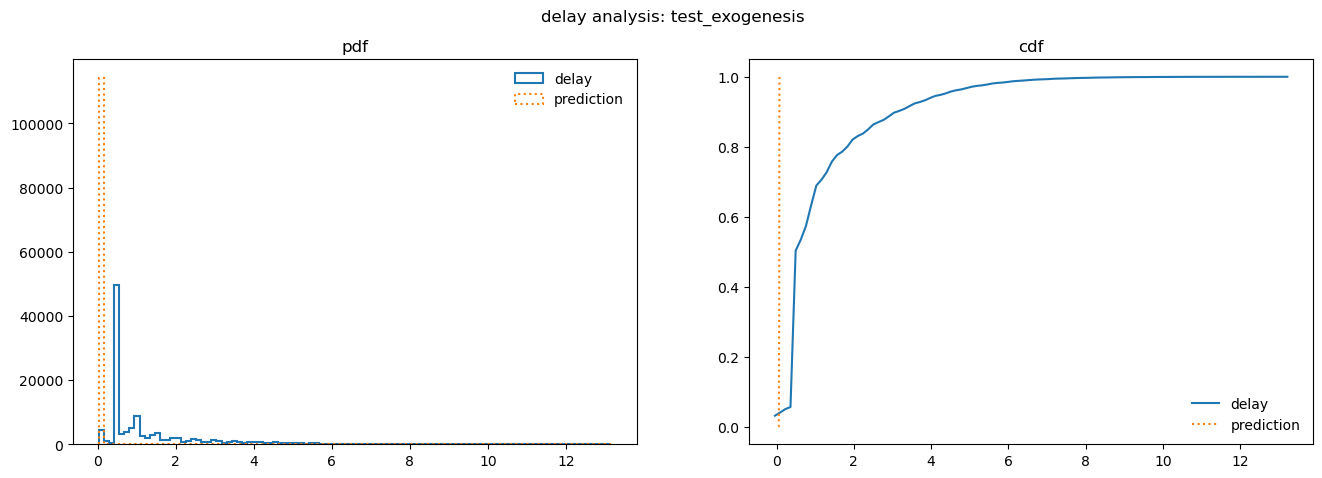

In [22]:
pdf_cdf(Result*1e3, disp='train') 
pdf_cdf(Result1*1e3, disp='test_endogeny')   
pdf_cdf(Result2*1e3, disp='test_exogenesis')

### Plotting Logs

No handles with labels found to put in legend.


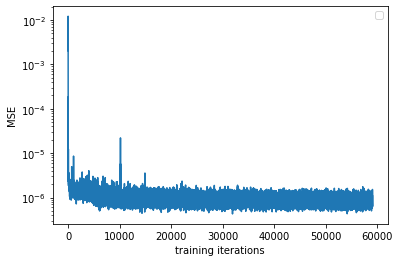

In [ ]:
with open("logs/train_same_batch.log") as file:
    lines = file.readlines()
loss = []
iterations = []
for i in range(len(lines)):
    iterations.append(i+1)
    loss.append(float(lines[i].strip('\n').split('\t')[-1]))
plt.plot(iterations, loss )
plt.xlabel("training iterations")
plt.ylabel("MSE")
plt.yscale('log')
plt.legend()
plt.show()

No handles with labels found to put in legend.


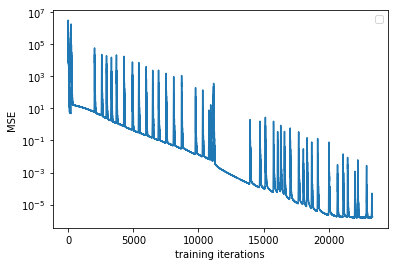

In [ ]:
with open("logs/train_nolstm.log") as file:
    lines = file.readlines()
loss = []
iterations = []
for i in range(len(lines)):
    iterations.append(i+1)
    loss.append(float(lines[i].strip('\n').split('\t')[-1]))
plt.plot(iterations, loss )
plt.xlabel("training iterations")
plt.ylabel("MSE")
plt.yscale('log')
plt.legend()
plt.show()

No handles with labels found to put in legend.


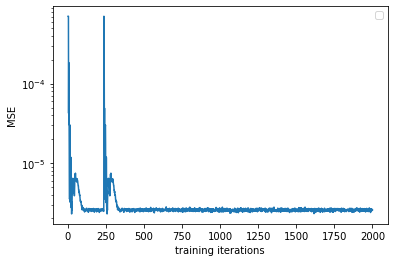

In [ ]:
#### learning curve plot for bi-lstm

with open("logs/train_100epochs_l2_bilstm.log") as file:
    lines = file.readlines()
loss = []
iterations = []
for i in range(len(lines)):
    iterations.append(i+1)
    loss.append(float(lines[i].strip('\n').split('\t')[-1]))
plt.plot(iterations[:2000], loss[:2000] )
plt.xlabel("training iterations")
plt.ylabel("MSE")
plt.yscale('log')
plt.legend()
plt.show()

No handles with labels found to put in legend.


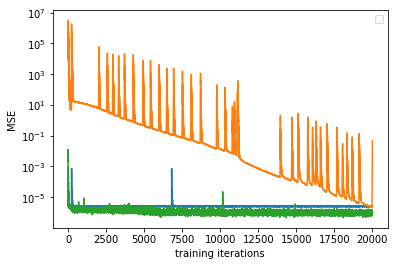

In [ ]:
#### learning curve plot for bi-lstm, lstm and linear

with open("logs/train_100epochs_l2_bilstm.log") as file:
    lines = file.readlines()
loss_1 = []
iterations_1 = []
for i in range(len(lines)):
    iterations_1.append(i+1)
    loss_1.append(float(lines[i].strip('\n').split('\t')[-1]))
plt.plot(iterations_1[:20000], loss_1[:20000], label="bi-LSTM")

with open("logs/train_nolstm.log") as file:
    lines = file.readlines()
loss_2 = []
iterations_2 = []
for i in range(len(lines)):
    iterations_2.append(i+1)
    loss_2.append(float(lines[i].strip('\n').split('\t')[-1]))
plt.plot(iterations_2[:20000], loss_2[:20000], label="Linear" )

with open("logs/train_same_batch.log") as file:
    lines = file.readlines()
loss_3 = []
iterations_3 = []
for i in range(len(lines)):
    iterations_3.append(i+1)
    loss_3.append(float(lines[i].strip('\n').split('\t')[-1]))
plt.plot(iterations_3[:20000], loss_3[:20000], label="LSTM"  )
plt.xlabel("training iterations")
plt.ylabel("MSE")
plt.yscale('log')
plt.legend()
plt.show()